A notebook to test Nystrom HSIC implementation.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import fsic.util as util
import fsic.data as data
import fsic.feature as fea
import fsic.kernel as kernel
import fsic.indtest as it
import scipy.stats as stats

In [2]:
# font options
font = {
    #'family' : 'normal',
    #'weight' : 'bold',
    'size'   : 16
}

plt.rc('font', **font)
plt.rc('lines', linewidth=2)
#matplotlib.rc('text', usetex=True)
#matplotlib.rcParams['text.latex.preamble']=[r"\usepackage{amsmath}"]

In [3]:
def get_quad_psfunc():
    """
    Return a PairedSource to generate y = x^2 + Gaussian noise.
    """
    px = lambda n: np.random.rand(n, 1)*8 - 4
    f = lambda x: 0.2*x**2 + np.random.randn(x.shape[0], 1)
    return data.PSFunc(f, px)
    

In [4]:
# paired source 
alpha = 0.05
n = 800
seed = 19

dx = 90 
dy = 50
#ps = data.PSIndSameGauss(dx, dy)
#ps = get_quad_psfunc()
#ps = data.PS2DUnifRotate(angle=np.pi/3)
#ps = data.PSIndUnif(xlb=[0, 3], xub=[1, 10], ylb=[-5, 5], yub=[8, 10])
ps = data.PS2DSinFreq(freq=2)

pdata = ps.sample(n, seed=seed)
#tr, te = pdata.split_tr_te(tr_proportion=0.5, seed=10)

In [5]:
# get the median distances 
X, Y = pdata.xy()
medx = util.sampled_median_distance(X, 1000)
medy = util.sampled_median_distance(Y, 1000)
sigmax2 = medx**2
sigmay2 = medy**2
k = kernel.KGauss(sigmax2)
l = kernel.KGauss(sigmay2)

# Randomly choose inducing points.
D = 20
induce_x = X[util.subsample_ind(n, D, seed=seed+1), :]
induce_y = Y[util.subsample_ind(n, D, seed=seed+2), :]

n_simulate = 5000
nyhsic = it.NystromHSIC(k, l, induce_x, induce_y, 
                       n_simulate=n_simulate, alpha=alpha, seed=seed+10)

In [6]:
nyhsic_result = nyhsic.perform_test(pdata)
nyhsic_result

{'alpha': 0.05,
 'pvalue': 0.0032,
 'test_stat': 1.0726264965810834,
 'h0_rejected': True,
 'time_secs': 0.5730116367340088,
 'n_simulate': 5000}

## Null distribution

Check that the distribution simulated from the spectral approach is the same as the one obtained by permutations.

In [7]:
n_permute = 1000
n_simulate = 1000
fmx = nyhsic.fmx
fmy = nyhsic.fmy

Zx = fmx.gen_features(X)
Zy = fmy.gen_features(Y)
list_perm = it.FiniteFeatureHSIC.list_permute(X, Y, fmx, fmy, n_permute=n_permute, seed=100)
list_spectral, eigx, eigy = it.FiniteFeatureHSIC.list_permute_spectral(Zx, Zy, 
                                                           n_simulate=n_simulate, seed=119)

In [8]:
freq_p, edge_p = np.histogram(list_perm)
freq_s, edge_s = np.histogram(list_spectral)
nfreq_p = freq_p/float(np.sum(freq_p))
nfreq_s = freq_s/float(np.sum(freq_s))
np.abs(nfreq_p-nfreq_s)


array([0.169, 0.102, 0.058, 0.083, 0.06 , 0.025, 0.018, 0.013, 0.007,
       0.007])

/usr/lib/python3/dist-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  after removing the cwd from sys.path.
/usr/lib/python3/dist-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  """


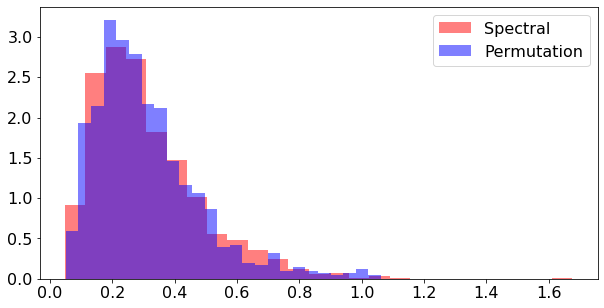

In [9]:
# histogram
plt.figure(figsize=(10, 5))
#plt.hist(list_perm, color='blue', alpha=0.7, normed=True, bins=20)
plt.hist(list_spectral, color='red', alpha=0.5, normed=True, bins=25, label='Spectral')
plt.hist(list_perm, color='blue', alpha=0.5, normed=True, bins=25, label='Permutation')
plt.legend()